In [1]:
import tensorflow as tf
import numpy as np
from modules.data import simulate_schrodinger
from modules.plots import plot_training_loss, plot_schrodinger_model
from modules.models import SchrodingerPinn
from modules.utils import load_mat_data

2022-12-20 17:10:26.215826: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def f_init(tx):
    h = 2.0 / tf.cosh(tx[:, 1:2])
    return tf.concat([h, tf.zeros_like(h)], axis=1)

In [3]:
nls_data = load_mat_data("data/NLS.mat")
u_exact = nls_data['uu'].T.flatten()[:, None]
h_exact = np.real(u_exact)
v_exact = np.imag(u_exact)
t_exact = nls_data['tt'].reshape(-1, 1)
x_exact = nls_data['x'].reshape(-1, 1)
X, T = np.meshgrid(x_exact,t_exact) 
X_star = np.hstack((T.flatten()[:,None], X.flatten()[:,None]))
data_exact = np.hstack((X_star, h_exact, v_exact))  

In [4]:
x_start = -5
length = 10
time = np.pi / 2
(tx_samples, y_samples), (tx_init, h_init), tx_boundary = simulate_schrodinger(5000, f_init, x_start, length, time)

2022-12-20 17:10:28.876700: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_SYSTEM_DRIVER_MISMATCH: system has unsupported display driver / cuda driver combination
2022-12-20 17:10:28.876757: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: nimooli-fedora
2022-12-20 17:10:28.876766: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: nimooli-fedora
2022-12-20 17:10:28.876894: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.60.11
2022-12-20 17:10:28.876921: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 520.56.6
2022-12-20 17:10:28.876929: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 520.56.6 does not match DSO version 525.60.11 -- cannot find working devices in this configuration
2022-12-20 17:10:28.877195: I tensorflow/core/platform/cpu_feature_guard.cc:193] T

In [5]:
network = SchrodingerPinn.build_network([64, 64, 64])
sch_pinn = SchrodingerPinn(network)
sch_pinn.compile()

In [6]:
inputs = tf.stack([tx_samples, tx_init, tx_boundary], axis=0)
outputs = tf.stack([h_init])

In [16]:
scheduler = tf.keras.optimizers.schedules.ExponentialDecay(0.001, 500, 0.87)
optimizer = tf.keras.optimizers.Adam(scheduler)

In [17]:
history = sch_pinn.fit(inputs, outputs, epochs = 20000, optimizer=optimizer,\
    progress_interval = 200, n_boundary_samples=5000, exact_data=data_exact)

Epoch: 0 Loss: 1.2614 Total Elapsed Time: 4.78
Epoch: 200 Loss: 0.1646 Total Elapsed Time: 21.63
Epoch: 400 Loss: 0.1308 Total Elapsed Time: 39.30
Epoch: 600 Loss: 0.1209 Total Elapsed Time: 57.52
Epoch: 800 Loss: 0.1149 Total Elapsed Time: 75.63
Epoch: 1000 Loss: 0.1101 Total Elapsed Time: 94.11
Epoch: 1200 Loss: 0.1066 Total Elapsed Time: 113.38
Epoch: 1400 Loss: 0.1036 Total Elapsed Time: 134.36
Epoch: 1600 Loss: 0.1020 Total Elapsed Time: 155.85
Epoch: 1800 Loss: 0.0990 Total Elapsed Time: 177.32
Epoch: 2000 Loss: 0.0975 Total Elapsed Time: 199.23
Epoch: 2200 Loss: 0.0940 Total Elapsed Time: 220.55
Epoch: 2400 Loss: 0.0917 Total Elapsed Time: 242.14
Epoch: 2600 Loss: 0.0892 Total Elapsed Time: 263.81
Epoch: 2800 Loss: 0.0867 Total Elapsed Time: 283.94
Epoch: 3000 Loss: 0.0851 Total Elapsed Time: 302.16
Epoch: 3200 Loss: 0.0837 Total Elapsed Time: 320.56
Epoch: 3400 Loss: 0.0823 Total Elapsed Time: 338.87
Epoch: 3600 Loss: 0.0818 Total Elapsed Time: 357.46
Epoch: 3800 Loss: 0.0799 T

1/1 [==============================] - 0s 22ms/step


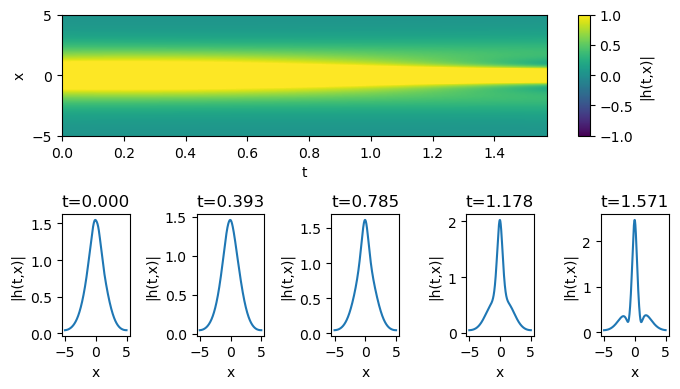

In [40]:
plot_schrodinger_model(sch_pinn.network, x_start, length, time)

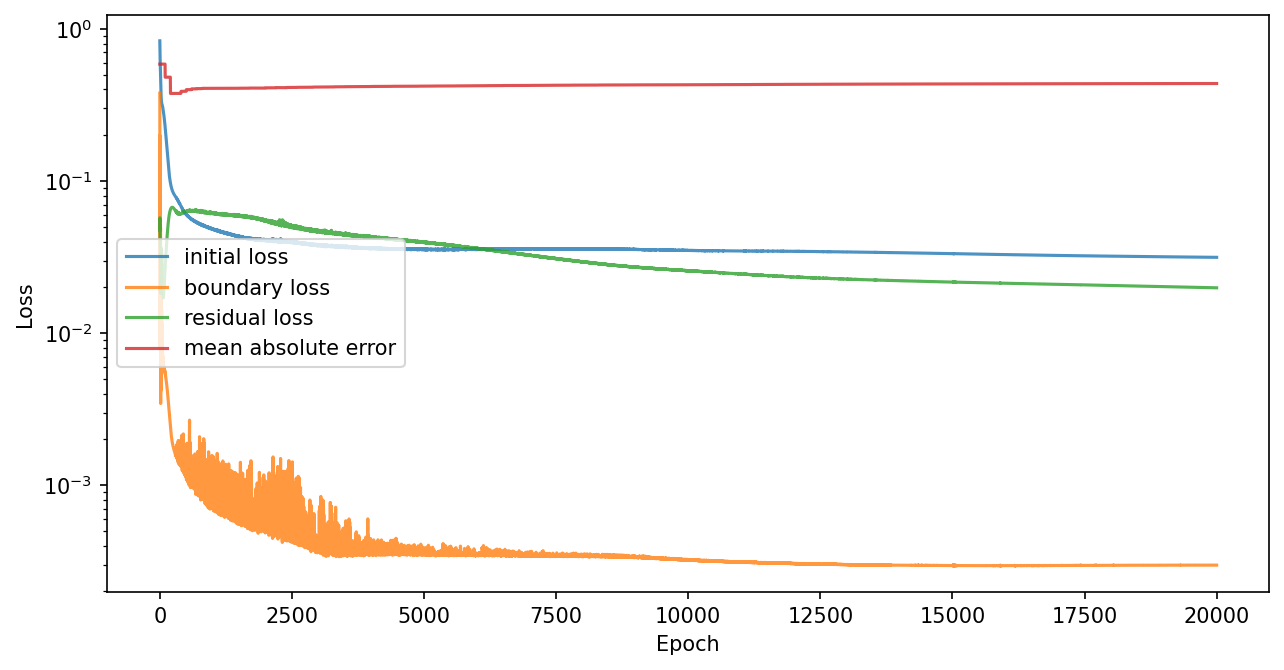

In [21]:
plot_training_loss(history, y_scale='log')

In [6]:
from modules.plots import plot_pointwise_error_mesh

In [8]:
u_preds = sch_pinn.network.predict(X_star)

1608/1608 [==============================] - 2s 1ms/step


In [9]:
u_preds_abs = tf.abs(tf.complex(u_preds[:, 0:1], u_preds[:, 1:2]))
u_exact_abs = tf.abs(tf.complex(h_exact, v_exact))
#convert to float32
u_preds_abs = tf.cast(u_preds_abs, tf.float32)
u_exact_abs = tf.cast(u_exact_abs, tf.float32)

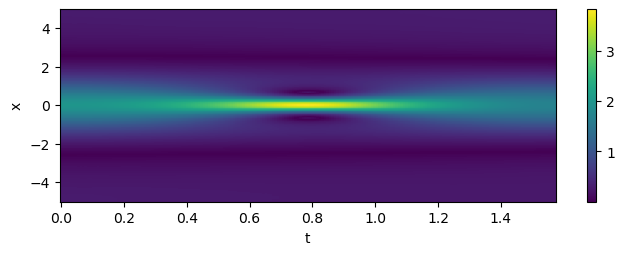

In [15]:
plot_pointwise_error_mesh(u_preds_abs, u_exact_abs, T, X, figsize=(8, 2.5))